In [11]:
! pip install keras==2.0.8


    100% |████████████████████████████████| 276kB 6.4MB/s 
keras-preprocessing 1.0.3 has requirement keras>=2.1.6, but you'll have keras 2.0.8 which is incompatible.
keras-applications 1.0.5 has requirement keras>=2.1.6, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 1.2.2
    Uninstalling Keras-1.2.2:
      Successfully uninstalled Keras-1.2.2


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
#### 2 GPU1
#### 0 GPU3
#### 4 GPU4
#### 3 GPU2
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)


python 3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
keras version 2.0.8
tensorflow version 1.11.0-rc2


In [0]:
class CharacterTable(object): 
    """Given a set of characters: 
     + Encode them to a one hot integer representation 
     + Decode the one hot integer representation to their character output 
     + Decode a vector of probabilities to their character output 
    """ 
    def __init__(self, chars): 
        """Initialize character table. 
  
         # Arguments 
             chars: Characters that can appear in the input. 
        """ 
        self.chars = sorted(set(chars)) 
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars)) 
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars)) 
 
 
    def encode(self, C, num_rows): 
        """One hot encode given string C. 
  
         # Arguments 
             num_rows: Number of rows in the returned one hot encoding. This is 
                 used to keep the # of rows for each data the same. 
         """ 
        x = np.zeros((num_rows, len(self.chars))) 
        for i, c in enumerate(C): 
             x[i, self.char_indices[c]] = 1 
        return x 
 
 
    def decode(self, x, calc_argmax=True): 
        if calc_argmax: 
            x = x.argmax(axis=-1) 
        return ''.join(self.indices_char[x] for x in x) 
class colors: 
    ok = '\033[92m' 
    fail = '\033[91m' 
    close = '\033[0m' 


In [4]:
import numpy as np

set_seed(123)
# Parameters for the model and dataset. 
TRAINING_SIZE = 10000
DIGITS = 1


# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 
# int is DIGITS. 
MAXLEN = DIGITS + 1 + DIGITS 

# All the numbers, plus sign and space for padding. 
chars = '0123456789+ ' 
ctable = CharacterTable(chars) 
f = lambda: int(''.join(np.random.choice(list('0123456789')) 
            for i in range(np.random.randint(1, DIGITS + 1)))) 
questions = [] 
expected = [] 
print('Generating data...') 
while len(questions) < TRAINING_SIZE: 
    if len(questions) % 1000 == 0:
           print("{} samples are generated...".format(len(questions)))
    a, b = f(), f()  
    q = '{}+{}'.format(a, b) 
    query = q + ' ' * (MAXLEN - len(q)) 
    ans = str(a + b) 
    # Answers can be of maximum size DIGITS + 1. 
    ans += ' ' * (DIGITS + 1 - len(ans))  
    questions.append(query) 
    expected.append(ans) 
print('Total addition questions:{}'.format( len(questions)))

Generating data...
0 samples are generated...
1000 samples are generated...
2000 samples are generated...
3000 samples are generated...
4000 samples are generated...
5000 samples are generated...
6000 samples are generated...
7000 samples are generated...
8000 samples are generated...
9000 samples are generated...
Total addition questions:10000


In [5]:
for q,a in zip(questions,expected):
    print("{:3} = {:4}".format(q,a))
    break

2+2 = 4   


In [6]:
def one_hot_encoder(expected,questions,x_dim,y_dim,chars,ctable):
    print('Vectorization...') 
    x = np.zeros((len(questions), x_dim, len(chars)), dtype=np.bool) 
    y = np.zeros((len(questions), y_dim, len(chars)), dtype=np.bool) 
    for i, sentence in enumerate(questions): 
         x[i] = ctable.encode(sentence, x_dim) 
    for i, sentence in enumerate(expected): 
         y[i] = ctable.encode(sentence, y_dim)
    return(x,y)
x, y = one_hot_encoder(expected,questions,MAXLEN,DIGITS + 1,chars,ctable)

Vectorization...


In [7]:
def split_train_test(x,y):
    # Explicitly set apart 10% for validation data that we never train over. 
    split_at = len(x) - len(x) // 10 
    (x_train, x_val) = x[:split_at], x[split_at:] 
    (y_train, y_val) = y[:split_at], y[split_at:] 
    return (x_train, x_val),(y_train, y_val)
(x_train, x_val),(y_train, y_val) = split_train_test(x,y)
print('Training Data:') 
print(x_train.shape) 
print(y_train.shape) 

Training Data:
(9000, 3, 12)
(9000, 2, 12)


In [0]:
HIDDEN_ENCODER=1
HIDDEN_DECODER=3

In [19]:
import keras.layers as layers
from keras.models import Model
from keras.layers.core import Dense


print('Build model...')

 

def define_model(MAXLEN_x,MAXLEN_y,chars,
                 HIDDEN_ENCODER,
                 HIDDEN_DECODER,RNN):
    
    def scalarToList(a):
        if not isinstance(a,list):
            a = [a]
        lena = len(a)
        return(a,lena)
    def return_seq(nlayer,lenEncoder):
        '''
        return sequence must be False if this layer is the final one
        '''
        return(False if nlayer == lenENCODER else True)

    
    HIDDEN_ENCODER, lenENCODER = scalarToList(HIDDEN_ENCODER)
    HIDDEN_DECODER, lenDECODER = scalarToList(HIDDEN_DECODER)

    
    inp = layers.Input(batch_shape=(None, MAXLEN_x, len(chars)),name="Input")  
    
    # "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE. 
    
    encoder = RNN(HIDDEN_ENCODER[0], 
                  return_sequences=return_seq(1,lenENCODER),
                  name="encoder1")(inp)
    
    nlayer = 1
    if lenENCODER > 1:
            for HE in HIDDEN_ENCODER[1:]:
                nlayer +=1
                encoder = RNN(HE, 
                          return_sequences=return_seq(nlayer,lenENCODER),
                          name="encoder"+str(nlayer))(encoder)
    
    rep_encoder = layers.RepeatVector(MAXLEN_y,name="repeat_vector")(encoder)
    # By setting return_sequences to True, return not only the last output but 
    # all the outputs so far in the form of (num_samples, timesteps, 
    # output_dim). This is necessary as TimeDistributed in the below expects 
    # the first dimension to be the timesteps.
    decoder = RNN(HIDDEN_DECODER[0],
                  return_sequences=True,
                  name="decoder1")(rep_encoder)
    
    if lenDECODER > 1:
            for HE in HIDDEN_DECODER[1:]:
                decoder = RNN(HE, 
                          return_sequences=True,
                          name=name+str(nlayer))(decoder)
    
    # Apply a dense layer to the every temporal slice of an input. For each of step 
    # of the output sequence, decide which character should be chosen. 
    #out = layers.Dense(len(chars))(decoder)
    out = layers.TimeDistributed(layers.Dense(len(chars),
                                              activation="softmax"),
                                 name="time_distributed_dense")(decoder)
    
    model = Model(inputs=[inp],outputs=[out])
    model = model.add_update(AttentionDecoder(150, ))
    encoder = Model(inputs=[inp],outputs=[rep_encoder])
    model.summary() 
    return(model,encoder)

HIDDEN_ENCODER = 1#128
HIDDEN_DECODER = 3#128
model, encoder = define_model(MAXLEN,DIGITS + 1,chars,
                              HIDDEN_ENCODER,
                              HIDDEN_DECODER,
                              RNN=layers.SimpleRNN)    

model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

Build model...


NameError: ignored

In [0]:
def print_predicted(x,y,model,ctable,colors):
    for i in range(x.shape[0]): 
        rowx, rowy = x[[i]], y[[i]]
        preds = model.predict(rowx, verbose=0) 
        preds = preds.argmax(axis=2)
        q = ctable.decode(rowx[0]) 
        correct = ctable.decode(rowy[0]) 
        guess = ctable.decode(preds[0], calc_argmax=False) 
        print('  Q:{}'.format(q)), 
        print('T:{}'.format( correct)), 
        print('Model:{}'.format(guess)),
        if correct == guess: 
             print(colors.ok + '☑' + colors.close) 
        else: 
             print(colors.fail + '☒' + colors.close) 

In [0]:
def train(model,ctable,
          x_train,y_train,x_val,y_val,
          nb_epochs,print_every,BATCH_SIZE):
    history = {'acc':[],'loss':[],'val_acc':[],'val_loss':[]}
    for iteration in range(1, nb_epochs): 
        hist = model.fit(x_train, y_train, 
                         batch_size=BATCH_SIZE, 
                         epochs=1,
                         verbose=False, 
                         validation_data=(x_val, y_val))
        ## printing 
        if iteration % print_every ==0:
            print('-' * 50)
            print('Iteration {}'.format(iteration))

        for key in hist.history.keys():
            history[key].append(hist.history[key][0])
            if iteration % print_every ==0:
                print("{}:{:4.3f}".format(key,hist.history[key][0])),

        if iteration % print_every ==0:    
            print("")

        # Select 10 samples from the validation set at random so we can visualize 
        # errors. 
        if iteration % print_every ==0: 
            index = np.random.randint(0, len(x_val),10)
            print_predicted(x_val[index],y_val[index],
                            model,ctable,colors)
    return(history)

In [12]:
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

set_seed()
history = train(model,ctable,
          x_train,y_train,x_val,y_val,
          nb_epochs=50,print_every=1,BATCH_SIZE=128)

(9000, 3, 12) (9000, 2, 12) (1000, 3, 12) (1000, 2, 12)
--------------------------------------------------
Iteration 1
val_loss:2.413
val_acc:0.218
loss:2.464
acc:0.105

  Q:0+2
T:2 
Model:00
☒
  Q:9+7
T:16
Model:25
☒
  Q:3+3
T:6 
Model:+0
☒
  Q:7+0
T:7 
Model:  
☒
  Q:0+9
T:9 
Model:  
☒
  Q:1+0
T:1 
Model:00
☒
  Q:2+0
T:2 
Model:+0
☒
  Q:8+2
T:10
Model:  
☒
  Q:6+7
T:13
Model:25
☒
  Q:8+9
T:17
Model:11
☒
--------------------------------------------------
Iteration 2
val_loss:2.311
val_acc:0.375
loss:2.363
acc:0.341

  Q:8+7
T:15
Model:11
☒
  Q:6+3
T:9 
Model:  
☒
  Q:4+4
T:8 
Model:  
☒
  Q:2+7
T:9 
Model:11
☒
  Q:7+6
T:13
Model:11
☒
  Q:7+5
T:12
Model:11
☒
  Q:8+8
T:16
Model:  
☒
  Q:0+7
T:7 
Model: 1
☒
  Q:8+1
T:9 
Model: 1
☒
  Q:7+4
T:11
Model:11
☑
--------------------------------------------------
Iteration 3
val_loss:2.179
val_acc:0.406
loss:2.243
acc:0.406

  Q:1+2
T:3 
Model:  
☒
  Q:4+2
T:6 
Model:  
☒
  Q:6+1
T:7 
Model:11
☒
  Q:6+8
T:14
Model:11
☒
  Q:1+2
T:3 
Model:  
☒
  

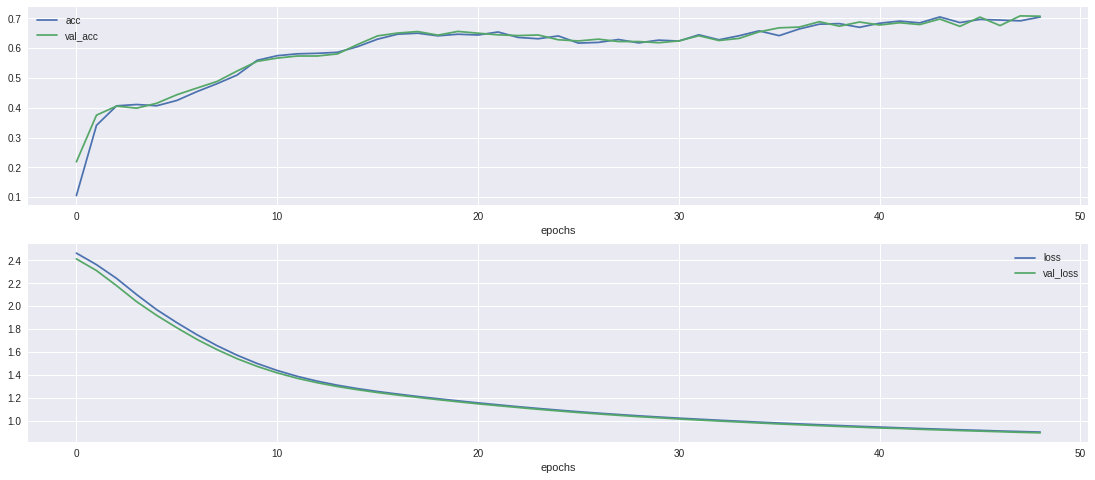

In [13]:
def plot_loss_acc(history):
    fig = plt.figure(figsize=(19,8))
    labels = [["acc","val_acc"],["loss","val_loss"]]

    count = 1
    for ilab in range(len(labels)):
        ax = fig.add_subplot(2,1,count)
        count += 1
        for label in labels[ilab]:
            ax.plot(history[label],label=label)
            ax.set_xlabel("epochs")    
        plt.legend()
    plt.show()
plot_loss_acc(history)

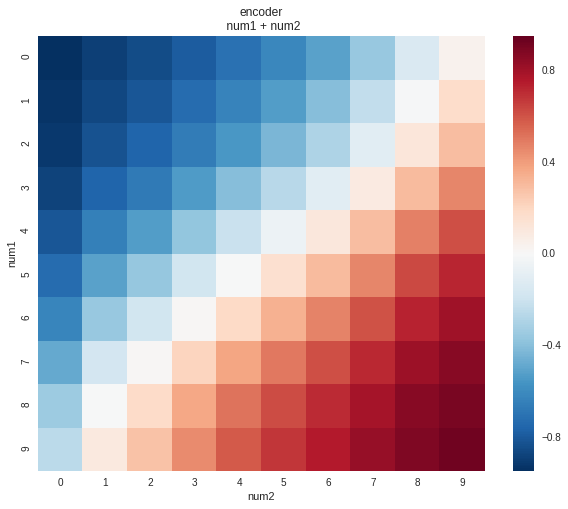

In [14]:
import seaborn as sns
import pandas as pd 

hidden = {"encoder": [],"num1":[],"num2":[]}
for num1 in range(10):
    for num2 in range(10):
        string = "{}+{}".format(num1,num2)
        myx = ctable.encode(string,MAXLEN)
        e = encoder.predict(myx.reshape(1,myx.shape[0],myx.shape[1]))[0]
        ## notice that the predicted encoders are duplicated twice k = 1 , 2 
        ## because of repeatVector
        ## we only extract one of the vector.
        if ~ np.all(e[0] == e[1]): ## should never be TRUE!
            print("ERROR!") 
        h = e[0]
        hidden["encoder"].append(h[0])    
        hidden["num1"].append(num1)
        hidden["num2"].append(num2)
hidden = pd.DataFrame(hidden)
sns.set()
plt.figure(figsize=(10,8))
sns.heatmap(hidden.pivot("num1","num2","encoder"))
plt.title("encoder\n num1 + num2")
plt.show()